**Do some calculations to figure out good targets for searching for TNO occultations, and when to observe these targets**

Using globular cluster catalog from William Harris https://physics.mcmaster.ca/~harris/mwgc.dat

In [303]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.time
import astropy.coordinates
import astropy.units as u
import os
import pandas as pd

In [304]:
# Open csv as pandas dataframe
gc_df = pd.read_csv(os.getcwd() + '/globular_cluster_catalog.csv')
gc_df.columns = gc_df.columns.str.strip()

In [316]:
# For each globular cluster in the catalog, find the ecliptic latitude and solar separation on a given date.
# 11-1-24 is for finding a good target for qCMOS on Hale Telescope
time = astropy.time.Time('2024-11-01T00:00:00', scale='utc')
sun_coord = astropy.coordinates.get_sun(time).geocentrictrueecliptic
for index, row in gc_df.iterrows():
    # Get the right ascension and declination
    ra = row['RA']
    dec = row['Dec']
    dist = row['R_Sun']
    # Convert to astropy SkyCoord
    c = astropy.coordinates.SkyCoord(ra=ra, dec=dec, distance=dist, unit=(u.hourangle, u.deg, u.kpc))
    # Get the ecliptic latitude
    ecl_lat = c.barycentrictrueecliptic.lat.deg
    omega = sun_coord.lon.deg - c.barycentrictrueecliptic.lon.deg - 180
    # Wrap omega to be between -180 and 180
    if omega > 180:
        omega -= 360
    elif omega < -180:
        omega += 360
    # Add to the dataframe
    gc_df.at[index, 'ecl_lat'] = ecl_lat
    gc_df.at[index, 'omega'] = omega

gc_df['V_t'] = pd.to_numeric(gc_df['V_t'], errors='coerce')

Choose a globular cluster target for qCMOS on the Hale Telescope

In [319]:
# Only look at globular clusters within 15 degrees of the ecliptic plane
gc_good_df = gc_df[abs(gc_df['ecl_lat']) < 30]
# Only look at globular clusters with V_t < 10
gc_good_df = gc_good_df[gc_good_df['V_t'] < 10]
# Only look at globular clusters less than 60 degrees from opposition
gc_good_df = gc_good_df[abs(gc_good_df['omega']) < 60]
print(gc_good_df[['ID', 'RA', 'Dec', 'Name', 'R_Sun', 'ecl_lat', 'omega', 'V_t']])

        ID           RA          Dec Name  R_Sun    ecl_lat      omega   V_t
1  NGC 288  00 52 45.24  -26 34 57.4         8.9 -29.453915  38.104659  8.09


In [380]:
def plot_airmass(ra, dec, lat, lon, date, height=0, local_time_offset=0):
    '''Plot the airmass of a target over the course of a night
    
    Parameters:
    ----------
    ra : str
        Right ascension of the target in hourangle
    dec : str
        Declination of the target in degrees
    lat : float
        Latitude of the observer, in degrees
    lon : float
        Longitude of the observer, in degrees
    date : str
        Date of the observation (date of the night, not the morning) in the format 'YYYY-MM-DD'
    local_time_offset : float
        Offset from UTC to local time in hours. California is -7 in Daylight Savings time
    height : float
        Height of the observer in meters
    '''
    # Want to start at 4PM local time and go to 8AM local time
    start_time = date + 'T16:00:00'
    start_time_utc = astropy.time.Time(start_time, scale='utc') - local_time_offset*u.hour
    times_utc = start_time_utc + np.linspace(0, 16, 10)*u.hour
    times = times_utc + local_time_offset*u.hour
    observer = astropy.coordinates.EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=height)
    # For each time, calculate the sun altitude
    sun_coords = astropy.coordinates.get_sun(times_utc)
    sun_alts = sun_coords.transform_to(astropy.coordinates.AltAz(obstime=times_utc, location=observer)).alt.deg
    # Get point where sun_alt goes from positive to negative, which is sunset
    sunset = times[np.where(sun_alts < 0)[0][0]]
    # Get point where sun_alt goes from negative to positive, which is sunrise
    sunrise = times[np.where(sun_alts > 0)[0][0]]
    print(sunset, sunrise)
    # print(sunset, sunrise)
    # target = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))
    # altaz = target.transform_to(astropy.coordinates.AltAz(obstime=time, location=observer))
    # # Plot the airmass
    # plt.plot(altaz.secz, label='Airmass')
    # plt.xlabel('Time')
    # plt.ylabel('Airmass')
    # plt.title('Airmass vs Time')
    # plt.legend()
    # plt.show()

plot_airmass(ra='00h52m45.24s', dec='-26d34m57.4s', lat=33.3563, lon=-116.8650, height=1706*u.m, date='2024-10-30', local_time_offset=-7)

2024-10-30T19:33:20.000 2024-10-30T16:00:00.000


NGC 288 will rise at: 2024-11-01 17:00:00.000
NGC 288 will set at: 2024-11-02 17:00:00.000


/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_13372/169430547.py:53: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(visible_times.plot_date, airmass, fmt='-')


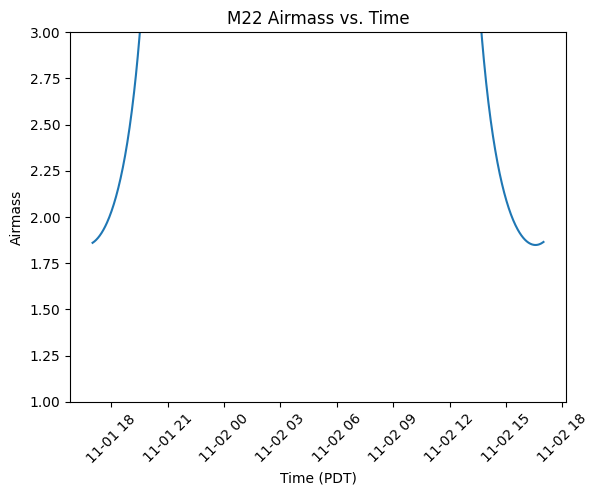

In [398]:
# Define the location of Palomar Observatory
target_name = "M22"
palomar = astropy.coordinates.EarthLocation(lat=33.3563*u.deg, lon=-116.8650*u.deg, height=1706*u.m)

# Define the observation time (October 30, 2024)
time = astropy.time.Time('2024-11-02 00:00:00') + np.linspace(0, 24, 1000)*u.hour

# NGC 288 Coordinates
ngc288_coord = astropy.coordinates.SkyCoord(ra='00h52m45.24s', dec='-26d34m57.4s', frame='icrs')
andromeda_coord = astropy.coordinates.SkyCoord(ra='00h42m44.3s', dec='41d16m9s', frame='icrs')
orion_coord = astropy.coordinates.SkyCoord(ra='05h35m17.3s', dec='-05d23m28s', frame='icrs')
grb_241030a_coord = astropy.coordinates.SkyCoord(ra='22h52m33.57s', dec='80d26m59.9s', frame='icrs')
m15_coord = astropy.coordinates.SkyCoord(ra='21h29m58.33s', dec='12d10m01.2s', frame='icrs')
terzan_5_coord = astropy.coordinates.SkyCoord(ra='17h48m05.6s', dec='-24d46m48s', frame='icrs')
m22_coord = astropy.coordinates.SkyCoord(ra='18h36m23.94s', dec='-23d54m17.1s', frame='icrs')
omega_centauri_coord = astropy.coordinates.SkyCoord(ra='13h26m47.24s', dec='-47d28m46.1s', frame='icrs')
tuc_47_coord = astropy.coordinates.SkyCoord(ra='22h51m10.0s', dec='-60d33m44s', frame='icrs')
ztf224342_coord = astropy.coordinates.SkyCoord(ra='22h43m43.0s', dec='+54d42m06s', frame='icrs')
crab_nebula_coord = astropy.coordinates.SkyCoord(ra='05h34m31.97s', dec='+22d00m52.1s', frame='icrs')
ep241021a_coord = astropy.coordinates.SkyCoord(ra='01h55m23.0s', dec='5d56m18s', frame='icrs')
amcvn_coord = astropy.coordinates.SkyCoord(ra='12h34m54.60s', dec='37d37m44.1s', frame='icrs')
eagle_coord = astropy.coordinates.SkyCoord(ra='18h18m48.0s', dec='-13d47m46s', frame='icrs')
ztfJ0703_coord = astropy.coordinates.SkyCoord(ra='07h03m58.0s', dec='+46d03m47s', frame='icrs')
toi392_coord = astropy.coordinates.SkyCoord(ra='03h 07m 44.00s', dec='+00d51m41.00s', frame='icrs')
toi1408b_coord = astropy.coordinates.SkyCoord(ra='20h 54m 03.00s', dec='+72d34m50.00s', frame='icrs')
pleiades_coord = astropy.coordinates.SkyCoord(ra='03h 47m 24s', dec='+24d07m00s', frame='icrs')
hat_p_20b_coord = astropy.coordinates.SkyCoord(ra='07h 27m 40.00s', dec='+24d20m15.00s', frame='icrs')

# Create AltAz frame for Palomar location and observation times
altaz_frame = astropy.coordinates.AltAz(obstime=time, location=palomar)

# Transform target coordinates to AltAz frame
target_altaz = m22_coord.transform_to(altaz_frame)

# Calculate the times when NGC 288 is above the horizon (altitude > 0)
is_visible = target_altaz.alt > 0*u.deg

# Get the times for which NGC 288 is visible
visible_times = time[is_visible]
# Convert visible times to pacific time
visible_times = visible_times - 7*u.hour
# Calculate the airamss for the visible times
airmass = target_altaz.secz[is_visible]

# Print the start and end time for visibility
if len(visible_times) > 0:
    print(f"NGC 288 will rise at: {visible_times[0].iso}")
    print(f"NGC 288 will set at: {visible_times[-1].iso}")
else:
    print("NGC 288 will not be visible on this date.")

# Plot the airmass as a function of time. Time should be labeled in HH:MM:SS
plt.plot_date(visible_times.plot_date, airmass, fmt='-')
# plt.xlim(visible_times[0].plot_date, visible_times[-300].plot_date)
plt.xticks(rotation=45)
plt.xlabel('Time (PDT)')
plt.ylabel('Airmass')
plt.ylim(1,3)
plt.title(target_name + ' Airmass vs. Time')
plt.show()


Look at some targets for TESS-GEO

In [309]:
# Find only globular clusters that are below 30 degrees ecliptic latitude and brighter than mag 8
gc_tess_geo = gc_df[abs(gc_df['ecl_lat']) < 20]
gc_tess_geo = gc_tess_geo[gc_tess_geo['V_t'] < 8]
print(gc_tess_geo[['ID', 'Name', 'R_Sun', 'ecl_lat', 'omega', 'V_t']])

              ID            Name  R_Sun    ecl_lat       omega   V_t
39    NGC 5904     M 5              7.5  19.646239  172.117772  5.65
43    NGC 5986                     10.4 -17.456306  155.910413  7.52
46    NGC 6093     M 80            10.0  -1.619061  152.287856  7.33
47    NGC 6121     M 4              2.2  -4.868774  150.223307  5.63
52    NGC 6171     M 107            6.4   8.765432  150.248170  7.93
59    NGC 6254     M 10             4.4  18.441181  145.253067  6.60
62    NGC 6266     M 62             6.8  -7.324307  141.493406  6.45
63    NGC 6273     M 19             8.8  -3.466644  141.568549  6.77
71    NGC 6333     M 9              7.9   4.580401  138.411032  7.72
95    NGC 6441                     11.6 -13.629209  130.718207  7.15
109   NGC 6544                      3.0  -1.568657  127.045680  7.77
122   NGC 6624                      7.9  -7.027363  123.566555  7.87
123   NGC 6626     M 28             5.5  -1.549026  123.142265  6.79
125   NGC 6637     M 69           

In [399]:
# Get ecliptic latitude of pleiades
pleiades = astropy.coordinates.SkyCoord(ra='03h 47m 24s', dec='+24d07m00s', frame='icrs')
pleiades_ecl_lat = pleiades.barycentrictrueecliptic.lat.deg
print(pleiades_ecl_lat)

4.066417005947422
